# 이원 분산 분석
이원 분산 분석(Two-way ANOVA)은 두 개의 범주형 독립변수(요인)가 종속변수에 미치는 영향을 동시에 검정하는 통계 기법입니다. 이 분석을 통해 각 요인의 주 효과(Main Effect)와 두 요인 간의 상호작용(Interaction Effect)이 종속변수에 미치는 영향을 파악할 수 있습니다.

이원 분산 분석에서는 세 가지 가설을 검정합니다.

```
요인 A의 주 효과
귀무가설 : 요인 A의 모든 수준에서 종속변수의 평균이 동일하다.
대립가설 : 적어도 한 수준에서 평균에 차이가 있다.

요인 B의 주 효과
귀무가설 : 요인 B의 모든 수준에서 종속변수의 평균이 동일하다.
대립가설 : 적어도 한 수준에서 평균에 차이가 있다.

상호작용 효과
귀무가설 : 요인 A와 요인 B 간에 상호작용 효과가 없다.
대립가설 : 요인 A와 요인 B가 결합하여 종속변수에 미치는 영향이 다르다.
```

* 정규성: 각 그룹(요인 조합)의 잔차가 정규분포를 따라야 합니다.
* 등분산성(동질성): 모든 그룹의 분산이 동일해야 합니다.
* 독립성: 각 관측치는 서로 독립적이어야 합니다.

In [5]:
import pandas as pd

tree = pd.read_csv("Data/tree.csv")
tree
# 나무 ABCD, 비료 123

,나무,비료,성장률
0,A,1,54.967142
1,A,1,48.617357
2,A,1,56.476885
3,A,1,65.230299
4,A,1,47.658466
...,...,...,...
115,D,3,74.015473
116,D,3,70.652882
117,D,3,59.313220
118,D,3,82.428228


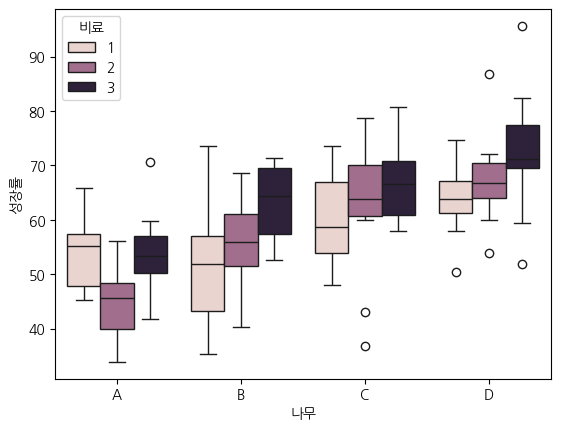

In [11]:
import seaborn as sns
import koreanize_matplotlib
import matplotlib.pyplot as plt

# 나무별 비료별 성장률 차이가 있는지 
sns.boxplot(data=tree, x = "나무", y = "성장률", hue = "비료")
plt.show()

# 일단은 그림상으로는 성장률의 차이가 존재하는 것처럼 보임

In [8]:
# 정규성 test... 원래처럼하면?

# 나무 A이면서 비료 1,2,3
# 나무 B이면서 비료 1,2,3
# 나무 C이면서 비료 1,2,3
# 나무 D이면서 비료 1,2,3        # 원래 하던것처럼 하면 12번해야됨   =>    groupby 활용

In [15]:
# 정규성 만족하는지 확인 - groupby, shapiro

from statsmodels.formula.api import ols
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats

for name, df in tree.groupby(["나무", "비료"]):         # groupby로 그룹화 
        st, p = stats.shapiro(df["성장률"])
        if p > 0.05:
            print(f"{name} : 정규성을 만족합니다")

('A', 1) : 정규성을 만족합니다
('A', 2) : 정규성을 만족합니다
('A', 3) : 정규성을 만족합니다
('B', 1) : 정규성을 만족합니다
('B', 2) : 정규성을 만족합니다
('B', 3) : 정규성을 만족합니다
('C', 1) : 정규성을 만족합니다
('C', 2) : 정규성을 만족합니다
('C', 3) : 정규성을 만족합니다
('D', 1) : 정규성을 만족합니다
('D', 2) : 정규성을 만족합니다
('D', 3) : 정규성을 만족합니다


In [19]:
# 분산이 동일한지 확인 - groupby, levene*

box = []
for name, df in tree.groupby(["나무", "비료"]):         # groupby로 그룹화 
    box.append(df["성장률"])
box

stats.levene(*box)

# p > 0.05 ; 분산도 동일하다고 추론 가능

LeveneResult(statistic=0.6304294467759749, pvalue=0.7993202544770085)

In [17]:
# 참고: *이 있으면 변수가 몇개든 ㄱㅊ음

def func(*x):
    return x

func(3,4)

(3, 4)

In [22]:
# 차이가 있는지 확인하는 방법 (이원분산분석)  - ols, stats.anova_lm

# 성장 차이를 보고 싶다 = variable을 가지고 value를 보고싶다 = value를 종속변수(y)로.
# 범주형 변수일 때는 앞에 C붙여줄것

from statsmodels.formula.api import ols
import statsmodels.api as sm

model = ols("성장률 ~ C(나무) + C(비료) + C(나무):C(비료)", data=tree).fit()
sm.stats.anova_lm(model)

# 나무, 비료, 나무&비료의 상호작용의 p < 0.05 ; H0기각. 적어도 두 개의 분산에 유의미한 차이가 있다

,df,sum_sq,mean_sq,F,PR(>F)
C(나무),3.0,4783.353938,1594.451313,18.855528,6.600012e-10
C(비료),2.0,1127.924259,563.962129,6.669256,1.857612e-03
C(나무):C(비료),6.0,717.520672,119.586779,1.414199,2.157357e-01
Residual,108.0,9132.639448,84.561476,NaN,NaN


In [23]:
# 사후 분석 - pairwise_tukeyhsd

# 어떤 나무가 유의미한지 확인 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

report = pairwise_tukeyhsd(endog = tree["성장률"], 
                           groups = tree['나무'], alpha = 0.05)
print(report)

# A와 B의 p > 0.05: 두 그룹의 평균차이는 통계적으로 유의하지 않다 

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B   5.6698 0.1143 -0.8776 12.2173  False
     A      C  12.0103    0.0  5.4628 18.5578   True
     A      D   16.679    0.0 10.1315 23.2264   True
     B      C   6.3405 0.0614  -0.207 12.8879  False
     B      D  11.0091 0.0002  4.4616 17.5566   True
     C      D   4.6686 0.2517 -1.8788 11.2161  False
----------------------------------------------------


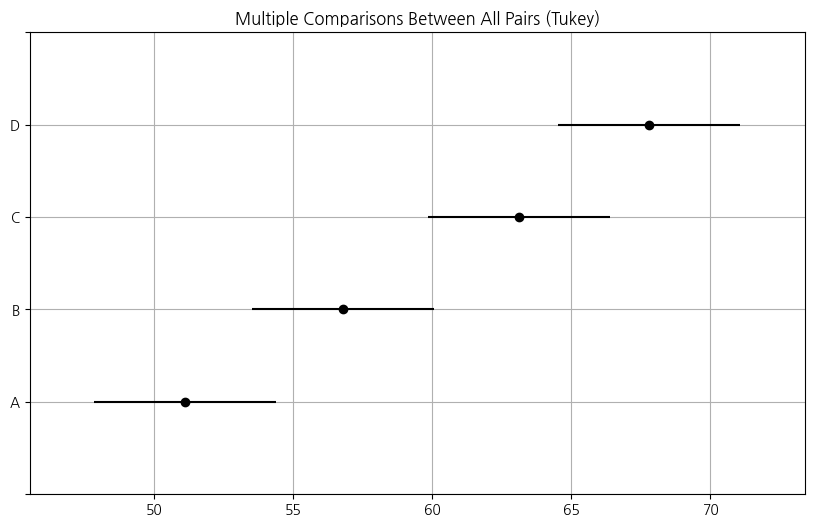

In [26]:
report.plot_simultaneous()
plt.grid()
plt.show()

In [ ]:
# 어떤 비료가 유의미한지 확인 
report2 = pairwise_tukeyhsd(endog = tree["성장률"], 
                           groups = tree['나무'], alpha = 0.05)
print(report2)

## 연습문제
한 연구자가 체중 감량에 미치는 두 가지 요인의 효과를 조사하고자 하였습니다.

```
요인 1: 식이 요법 (Diet)
    - 수준: 고단백 (HighProtein), 저탄수화물 (LowCarb), 균형 잡힌 식단 (Balanced)

요인 2: 운동 강도 (Exercise)
    - 수준: 낮음 (Low), 높음 (High)
```

주효과와 상호작용 효과를 포함하는 이원 분산 분석 모형을 구축하세요. (유의수준 0.05)

In [46]:
df = pd.read_csv("Data/식이요법과 운동강도.csv")
df

,Diet,Exercise,WeightLoss
0,HighProtein,Low,3.0
1,HighProtein,Low,3.5
2,HighProtein,Low,3.1
3,HighProtein,Low,3.3
4,HighProtein,Low,3.2
5,HighProtein,High,4.0
6,HighProtein,High,4.2
7,HighProtein,High,3.8
8,HighProtein,High,4.1
9,HighProtein,High,4.0


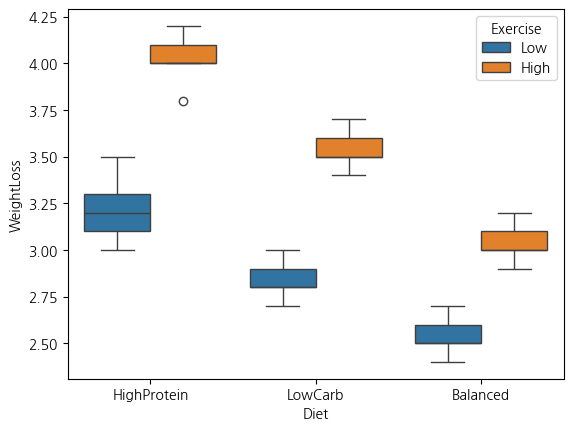

In [47]:
import seaborn as sns
import koreanize_matplotlib
import matplotlib.pyplot as plt

# 식이요법별 운동강도별 체중감량의 차이가 있는지 
sns.boxplot(data=df, x = "Diet", y = "WeightLoss", hue = "Exercise")
plt.show()

# 일단은 그림상으로는 체중감량의 차이가 존재하는 것처럼 보임

In [48]:
# 정규성 만족하는지 확인 - groupby, shapiro

from statsmodels.formula.api import ols
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats

for i, j in df.groupby(["Diet", "Exercise"]):         # groupby로 그룹화 
        st, p = stats.shapiro(j["WeightLoss"])
        if p > 0.05:
            print(f"{i} : 정규성을 만족합니다")

# 다 정규성 만족함 확인가능 

('Balanced', 'High') : 정규성을 만족합니다
('Balanced', 'Low') : 정규성을 만족합니다
('HighProtein', 'High') : 정규성을 만족합니다
('HighProtein', 'Low') : 정규성을 만족합니다
('LowCarb', 'High') : 정규성을 만족합니다
('LowCarb', 'Low') : 정규성을 만족합니다


In [49]:
# 분산이 동일한지 확인 - groupby, levene*

box = []
for i, j in df.groupby(["Diet", "Exercise"]):         # groupby로 그룹화 
    box.append(j["WeightLoss"])
box

stats.levene(*box)

# p > 0.05 ; 분산도 동일하다고 추론 가능

LeveneResult(statistic=0.3450980392156847, pvalue=0.8802963672362956)

In [50]:
# 차이가 있는지 확인하는 방법 (이원분산분석)  - ols, stats.anova_lm

# 체중 감량 차이를 보고 싶다 = variable을 가지고 value를 보고싶다 = value를 종속변수(y)로.
# 범주형 변수일 때는 앞에 C붙여줄것

from statsmodels.formula.api import ols
import statsmodels.api as sm

model = ols("WeightLoss ~ C(Diet) + C(Exercise) + C(Diet):C(Exercise)", data=df).fit()
# model = ols("WeightLoss ~ C(Diet) * C(Exercise)", data=df).fit()                   <<   이렇게 * 로 표현해서 해도 됨.
sm.stats.anova_lm(model)

# Diet, Exercise의 p < 0.05 ; H0기각. 적어도 두 개의 분산에 유의미한 차이가 있다
# Diet&Exercise의 상호작용의 p > 0.05 ;  효과가 없다?

,df,sum_sq,mean_sq,F,PR(>F)
C(Diet),2.0,3.446000,1.723000,93.135135,4.888779e-12
C(Exercise),1.0,3.333333,3.333333,180.180180,1.187511e-12
C(Diet):C(Exercise),2.0,0.116667,0.058333,3.153153,6.083294e-02
Residual,24.0,0.444000,0.018500,NaN,NaN


In [51]:
# 사후 분석 - pairwise_tukeyhsd

# 어떤 식이요법이 유의미한지 확인 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

report = pairwise_tukeyhsd(endog = df["WeightLoss"], 
                           groups = df['Diet'], alpha = 0.05)
print(report)

# Balanced와 LowCarb의 p > 0.05: 두 그룹의 평균차이는 통계적으로 유의하지 않다. 효과가 없다

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
   Balanced HighProtein     0.83 0.0001  0.4089  1.2511   True
   Balanced     LowCarb      0.4  0.065 -0.0211  0.8211  False
HighProtein     LowCarb    -0.43 0.0446 -0.8511 -0.0089   True
--------------------------------------------------------------


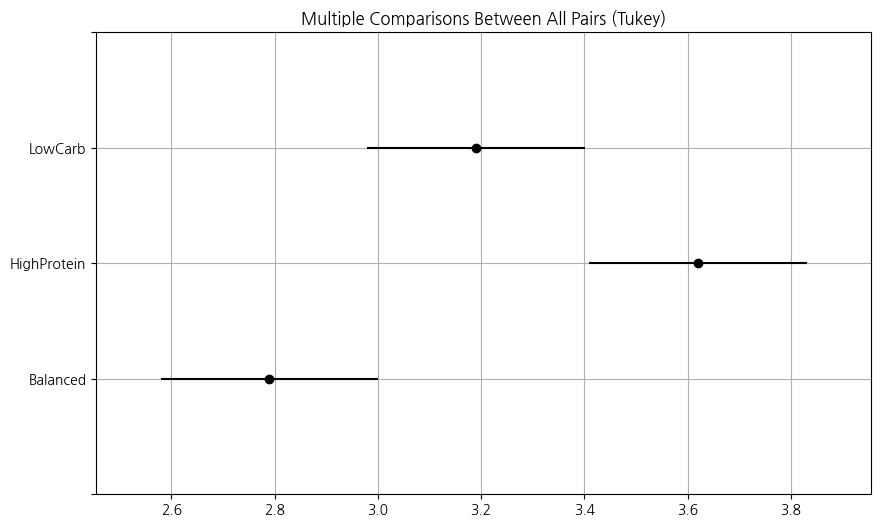

In [52]:
report.plot_simultaneous()
plt.grid()
plt.show()